In [111]:
import numpy as np
from collections import namedtuple
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, TapTool
from bokeh.models.callbacks import CustomJS

Vertex = namedtuple("Vertex", "vertex support")

callback_code = """
    var selected = data.selected.indices[0];
    var support = info[selected][1] ;
    var special = info[selected][1][info[selected][1].length-1] ;
    for(let i=0; i<pts.data['color'].length;i++){
        pts.data['color'][i]=support.includes(i)?'green':'blue';
        pts.data['size'][i]=support.includes(i)?10:4 ;
    }
    pts.data['color'][special]='#33ee00' ;
    pts.change.emit() ;
"""


class RCH:
    def __init__(self, pts, mu):
        self.pts = pts
        self.indices = np.array(range(pts.shape[0]))
        self.mu = mu
        first = self._top(self.pts, self.indices, np.array([0, 1]), self.mu)
        second = self._top(self.pts, self.indices, np.array([0, -1]), self.mu)
        L = self._RCH0(self.pts, self.indices, first, second, self.mu)
        R = self._RCH0(self.pts, self.indices, second, first, self.mu)
        self.rch = L[:-1] + R
        self.vertices = np.stack([x.vertex for x in self.rch])
        self.support = np.stack([pts[x.support] for x in self.rch])

    def fig(self, clickable=True, vertex_size=10):
        return self._fig(clickable,vertex_size)

    def _top(self, pts, indices, w, mu):
        p = pts[indices]
        k = int(np.ceil(1 / mu))
        z = np.dot(p, w.T)
        n_indices = np.argsort(-z)[:k]
        v = indices[n_indices]
        u = pts[v]
        vert = u[: (k - 1), :].sum(axis=0) * mu + (1 - (k - 1) * mu) * u[k - 1, :]
        return Vertex(vertex=vert, support=v)

    def _normal(self, x, y):
        z = y - x
        return np.array([-z[1], z[0]])

    def _bump(self, pts, indices, x, y, mu):
        z = self._normal(x.vertex, y.vertex)
        x_support = pts[x.support]
        y_support = pts[y.support]
        support = np.concatenate([x_support, y_support])
        p = pts[indices]
        A0 = indices[np.dot(p, z.T) >= np.min(np.dot(support, z.T))]
        return A0

    def _RCH0(self, pts, indices, left, right, mu):
        h = self._top(pts, indices, self._normal(left.vertex, right.vertex), mu)
        if (
            np.allclose(h.vertex, left.vertex)
            or np.allclose(h.vertex, right.vertex)
            or indices.shape[0] < 2
        ):
            return [left, right]
        A = self._bump(pts, indices, left, h, mu)
        B = self._bump(pts, indices, h, right, mu)
        x = self._RCH0(pts, A, left, h, mu)
        y = self._RCH0(pts, B, h, right, mu)
        return x[:-1] + y

    def _fig(self, clickable=True,vertex_size=10):
        f = figure(
            aspect_ratio=1.0, title="Reduced Convex Hull with \u03BC={:.2f}".format(self.mu)
        )
        N = self.pts.shape[0]
        data = ColumnDataSource(
            {"x": self.vertices[:-1, 0], "y": self.vertices[:-1, 1]}
        )
        data2 = ColumnDataSource({"x": self.vertices[:, 0], "y": self.vertices[:, 1]})
        points = ColumnDataSource(
            {
                "x": self.pts[:, 0],
                "y": self.pts[:, 1],
                "color": ["blue" for i in range(N)],
                "size": [4 for i in range(N)],
            }
        )
        callback = CustomJS(
            args=dict(data=data, info=self.rch, pts=points), code=callback_code
        )
        f.scatter(x="x", y="y", color="color", source=points, size="size")
        f.line(x="x", y="y", color="red", source=data2)
        vertices = f.circle(
            x="x",
            y="y",
            selection_color="red",
            color="red",
            nonselection_fill_alpha=0.5,
            size=vertex_size,
            source=data,
        )
        if clickable:
            f.add_tools(TapTool(callback=callback, renderers=[vertices]))
        return f

In [112]:
%setup

pandas=pd, numpy=np
bokeh models, figure, layouts loaded
output directed to notebook


Loading BokehJS ...

In [113]:
A = np.random.normal(-1,1,size=(20,2))
B = np.random.normal(1,1,size=(20,2))

In [114]:
f=figure()
f.scatter(x=A[:,0],y=A[:,1],color='blue')
f.scatter(x=B[:,0],y=B[:,1],color='green')
show(f)

In [115]:
C=10
Ar = RCH(A,1/C)
Br = RCH(B,1/C)

In [116]:
show(Ar.fig())

In [117]:
data2A = ColumnDataSource({"x": Ar.vertices[:, 0], "y": Ar.vertices[:, 1]})
data2B = ColumnDataSource({"x": Br.vertices[:, 0], "y": Br.vertices[:, 1]})

In [118]:
from sklearn.svm import SVC

In [119]:
data = np.concatenate([A,B],axis=0)
labels = np.concatenate([np.zeros(A.shape[0]),np.ones(B.shape[0])],axis=0)

In [120]:
labels.shape

(40,)

In [121]:
f=figure(title='Hyperplane Separating Reduced Convex Hulls')
f.scatter(x=A[:,0],y=A[:,1],color='blue')
f.scatter(x=B[:,0],y=B[:,1],color='green')
f.line(x="x", y="y", color="red", source=data2A)
f.line(x="x",y="y",color="red",source=data2B)
P = SVC(C=C,kernel='linear').fit(data,labels)
coefs = (P.dual_coef_.T*P.support_vectors_).sum(axis=0)
a = coefs[0]
b = coefs[1]
c = P.intercept_[0]
x = np.linspace(-3,3,100)
y=(-c-a*x)/b
f.line(x=x,y=y,color='red')
plus_indices = np.where(P.dual_coef_[0]>0)[0]
minus_indices = np.where(P.dual_coef_[0]<=0)[0]
pvecs= (P.dual_coef_.T[plus_indices]*P.support_vectors_[plus_indices,:]).sum(axis=0)
qvecs = (P.dual_coef_.T[minus_indices]*P.support_vectors_[minus_indices,:]).sum(axis=0)

show(f)

In [122]:
import matplotlib.pyplot as plt

In [124]:
P = SVC(kernel='poly',gamma=2)
P.fit(data,labels)

SVC(gamma=2, kernel='poly')

<Figure size 432x288 with 0 Axes>

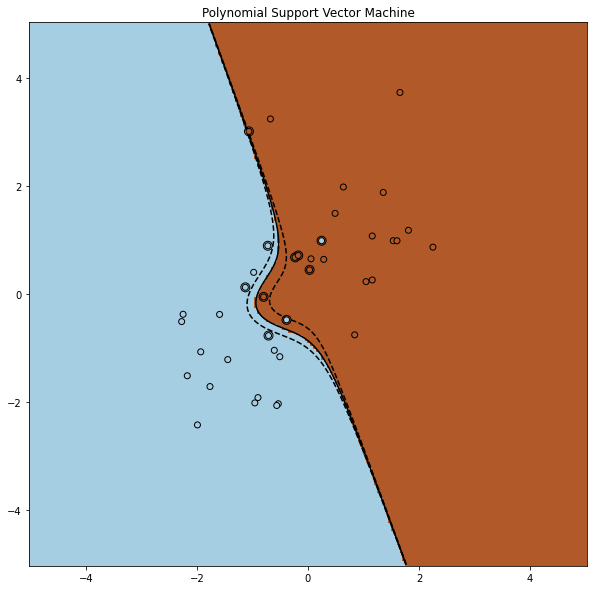

In [151]:
plt.clf()
fig=plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(10,10)
ax.scatter(P.support_vectors_[:,0],P.support_vectors_[:,1],s=80,facecolors='none',zorder=10,edgecolors='k')
ax.scatter(data[:,0],data[:,1],c=labels,zorder=10,cmap=plt.cm.Paired, edgecolors='k')
xx,yy = np.mgrid[-5:5:200j,-5:5:200j]
z = P.decision_function(np.c_[xx.ravel(),yy.ravel()])
z = z.reshape(xx.shape)
plt.pcolormesh(xx,yy,z > 0, cmap=plt.cm.Paired,shading='auto')
plt.contour(xx,yy,z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])
plt.title("Polynomial Support Vector Machine")
fig.savefig('/home/jet08013/GitHub/Math-3094-Spring-2021/SVM/img/PolynomialKernel.png')